In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/EzyDist/

/content/drive/My Drive/EzyDist


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as Zoo

import numpy as np

import matplotlib.pyplot as plt
import torch.nn.functional as F

import resnet
import net
import utils
import os


In [5]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./comp451/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=128, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./comp451/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=128, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./comp451/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [0]:
json_path = os.path.join('experiments/cnn_distill', 'params.json')
params = utils.Params(json_path)


In [0]:
student = net.Net(params)
student=student.to('cuda')
optimizer = optim.Adam(student.parameters(), lr=params.learning_rate)
# fetch loss function and metrics definition in model files
loss_fn_kd = net.loss_fn_kd
metrics = net.metrics

In [0]:
teacher_model = resnet.ResNet18()
teacher_checkpoint = 'experiments/base_resnet18/best.pth.tar'
teacher_model = teacher_model.to('cuda')


In [9]:
utils.load_checkpoint(teacher_checkpoint, teacher_model)

{'epoch': 115,
 'optim_dict': {'param_groups': [{'dampening': 0,
    'initial_lr': 0.1,
    'lr': 0.010000000000000002,
    'momentum': 0.9,
    'nesterov': False,
    'params': [140506516503192,
     140506516503272,
     140506516503352,
     140506516503512,
     140506516503592,
     140506516503672,
     140506516503752,
     140506516503832,
     140506516503912,
     140506516504152,
     140506516504232,
     140506516504312,
     140506516504392,
     140506516504472,
     140506516500952,
     140506507907384,
     140506507907464,
     140506507907544,
     140506507907624,
     140506507907704,
     140506507907784,
     140506507907944,
     140506507908024,
     140506507908104,
     140506507908264,
     140506507908344,
     140506507908424,
     140506507908504,
     140506507908584,
     140506507908664,
     140506507908984,
     140506507909144,
     140506507909224,
     140506507909384,
     140506507909464,
     140506507909544,
     140506507909704,
     1405065

In [0]:
def loss_fn_kd(outputs, labels, teacher_outputs):
    """
    Compute the knowledge-distillation (KD) loss given outputs, labels.
    "Hyperparameters": temperature and alpha
    NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
    and student expects the input tensor to be log probabilities! See Issue #2
    """
    alpha = params.alpha
    T = params.temperature
    KD_loss = nn.KLDivLoss()(F.log_softmax(outputs/T, dim=1),
                             F.softmax(teacher_outputs/T, dim=1)) * (alpha * T * T) + \
              F.cross_entropy(outputs, labels) * (1. - alpha)

    return KD_loss

In [0]:
def train(model,teacher, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to('cuda')  # move the model parameters to CPU/GPU
    teacher = teacher.to('cuda')  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            teacher.eval()
            x = x.to('cuda')  # move to device, e.g. GPU
            y = y.to('cuda')

            scores = model(x)
            with torch.no_grad():
              lecture= teacher(x)
            #print('scores: ', scores.data.shape)
            #print('lecture: ', lecture.data.shape)
            
            loss = loss_fn_kd(scores, y, lecture)
            #loss=stsegLoss(scores,lecture)
            #loss= cross_entropy2d(scores,y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                #metr=check_accuracy(val_loader, model)
                #print('Iteration %d, val_loss = %.4f' % (t, metr))
                #print(metr)
                print()

In [0]:
for t, (x, y) in enumerate(loader_train):break

teacher_model.eval()

x = x.to('cuda')  # move to device, e.g. GPU
y = y.to('cuda')

with torch.no_grad(): 
  lecture= teacher_model(x)
  guest=student(x)

In [13]:
print(lecture.shape)
print(guest.shape)

torch.Size([128, 10])
torch.Size([128, 10])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


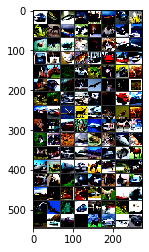

In [14]:
x=x.data.cpu()
img=torchvision.utils.make_grid(x)
img = img / 2 + 0.2    # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [15]:
train(student,teacher_model,optimizer,30)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Iteration 0, loss = 1.1402

Iteration 100, loss = 0.6488

Iteration 200, loss = 0.5958

Iteration 300, loss = 0.5185

Iteration 0, loss = 0.4686

Iteration 100, loss = 0.4729

Iteration 200, loss = 0.4447

Iteration 300, loss = 0.4338

Iteration 0, loss = 0.3897

Iteration 100, loss = 0.4418

Iteration 200, loss = 0.3638

Iteration 300, loss = 0.4055

Iteration 0, loss = 0.3468

Iteration 100, loss = 0.3881

Iteration 200, loss = 0.3551

Iteration 300, loss = 0.4039

Iteration 0, loss = 0.3142

Iteration 100, loss = 0.3423

Iteration 200, loss = 0.3376

Iteration 300, loss = 0.3608

Iteration 0, loss = 0.3236

Iteration 100, loss = 0.3143

Iteration 200, loss = 0.3283

Iteration 300, loss = 0.3208

Iteration 0, loss = 0.3101

Iteration 100, loss = 0.2809

Iteration 200, loss = 0.2764

Iteration 300, loss = 0.3491

Iteration 0, loss = 0.2818

Iteration 100, loss = 0.2833

Iteration 200, loss = 0.3631

Iteration 300, loss = 0.3161

Iteration 0, loss = 0.2552

Iteration 100, loss = 0.2709

In [0]:
def evaluate_kd(model, dataloader, metrics, params):
    """Evaluate the model on `num_steps` batches.
    Args:
        model: (torch.nn.Module) the neural network
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to evaluation mode
    model.eval()

    # summary for current eval loop
    summ = []

    # compute metrics over the dataset
    for i, (data_batch, labels_batch) in enumerate(dataloader):

        # move to GPU if available
        data_batch = data_batch.to('cuda')
        labels_batch = labels_batch.to('cuda')
        # fetch the next evaluation batch
        
        # compute model output
        output_batch = model(data_batch)

        # loss = loss_fn_kd(output_batch, labels_batch, output_teacher_batch, params)
        loss = 0.0  #force validation loss to zero to reduce computation time

        # extract data from torch Variable, move to cpu, convert to numpy arrays
        output_batch = output_batch.data.cpu().numpy()
        labels_batch = labels_batch.data.cpu().numpy()

        # compute all metrics on this batch
        summary_batch = {metric: metrics[metric](output_batch, labels_batch)
                         for metric in metrics}
        # summary_batch['loss'] = loss.data[0]
        summary_batch['loss'] = loss
        summ.append(summary_batch)

    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]} 
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())

    return metrics_mean

In [17]:
evaluate_kd(student,loader_val,metrics,params)

{'accuracy': 0.8001802884615384, 'loss': 0.0}

In [0]:
resnetMet=resnet.metrics

In [19]:
evaluate_kd(teacher_model,loader_val,resnetMet,params)

{'accuracy': 0.9948918269230769, 'loss': 0.0}